# **Segmentez des clients d'un site e-commerce**

**Essais des clusters**

In [ ]:
pip install numpy pandas scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msn
import seaborn as sns
import plotly.express as px
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer, IterativeImputer
from sklearn.linear_model import LinearRegression

In [ ]:
# Afficher toutes les colonnes
pd.options.display.max_columns = None

In [ ]:
data_orders = pd.read_csv('orders.csv')
data_order_items = pd.read_csv('order_items.csv')
data_order_pymts = pd.read_csv('order_pymts.csv')
data_geoloc = pd.read_csv('geoloc.csv')
data_order_reviews = pd.read_csv('order_reviews.csv')
data_sellers = pd.read_csv('sellers.csv')
data_translation = pd.read_csv('translation.csv')
data_products = pd.read_csv('products.csv')
data_customers = pd.read_csv('customers.csv')


# **Creation du fichier client**

In [ ]:
import pandas as pd
import sqlite3
# Connexion à la base de données
conn = sqlite3.connect('olist.db')

In [ ]:
import sqlite3
import pandas as pd

# Connexion à la base de données
conn = sqlite3.connect('olist.db')

# Définition de la requête SQL avec les nouveaux noms de colonnes
query = """
WITH
    Frequence AS (
        SELECT
            c.customer_unique_id,
            COUNT(DISTINCT o.order_id) AS frequence
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id
    ),
    Montant AS (
        SELECT
            c.customer_unique_id,
            SUM(oi.price) AS total_amount_spent
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        JOIN order_items oi ON o.order_id = oi.order_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id
    ),
    ScoreReview AS (
        SELECT
            c.customer_unique_id,
            AVG(r.review_score) AS average_review_score
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        JOIN order_reviews r ON o.order_id = r.order_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id
    ),
    LastOrder AS (
        SELECT
            c.customer_unique_id,
            MAX(o.order_delivered_customer_date) AS last_order_date,
            DATE('now') - MAX(o.order_delivered_customer_date) AS days_since_last_order,
            MIN(o.order_purchase_timestamp) AS first_order_date
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id
    ),
    OrderValues AS (
        SELECT
            c.customer_unique_id,
            AVG(oi.price) AS average_order_value,
            MAX(oi.price) AS max_order_value,
            AVG(oi.freight_value) AS average_freight_value
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        JOIN order_items oi ON o.order_id = oi.order_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id
    ),
    PaymentTypes AS (
        SELECT
            c.customer_unique_id,
            p.payment_type,
            COUNT(p.payment_type) AS payment_count
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id
        JOIN order_pymts p ON o.order_id = p.order_id
        WHERE o.order_status <> 'canceled'
            AND o.order_delivered_customer_date IS NOT NULL
        GROUP BY c.customer_unique_id, p.payment_type
    ),
    FrequentPaymentType AS (
        SELECT
            customer_unique_id,
            payment_type,
            payment_count,
            RANK() OVER (PARTITION BY customer_unique_id ORDER BY payment_count DESC) AS payment_rank
        FROM PaymentTypes
    )
SELECT
    f.customer_unique_id,
    f.frequence,
    m.total_amount_spent,  -- Total des montants dépensés
    sr.average_review_score,  -- Score de revue moyen
    lo.days_since_last_order,
    lo.first_order_date,
    ov.average_order_value,
    ov.max_order_value,
    ov.average_freight_value,
    ftp.payment_type AS most_frequent_payment_type
FROM Frequence f
JOIN Montant m ON f.customer_unique_id = m.customer_unique_id
JOIN ScoreReview sr ON f.customer_unique_id = sr.customer_unique_id
JOIN LastOrder lo ON f.customer_unique_id = lo.customer_unique_id
JOIN OrderValues ov ON f.customer_unique_id = ov.customer_unique_id
LEFT JOIN FrequentPaymentType ftp ON f.customer_unique_id = ftp.customer_unique_id AND ftp.payment_rank = 1;
"""

# Exécution de la requête et récupération des données dans un DataFrame
data_fichier_clients = pd.read_sql_query(query, conn)

# Afficher les résultats
display(data_fichier_clients.head())

# Fermer la connexion
conn.close()


,customer_unique_id,frequence,total_amount_spent,average_review_score,days_since_last_order,first_order_date,average_order_value,max_order_value,average_freight_value,most_frequent_payment_type
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,5.0,6,2018-05-10 10:56:27,129.90,129.90,12.00,credit_card
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,4.0,6,2018-05-07 11:11:27,18.90,18.90,8.29,credit_card
2,0000f46a3911fa3c0805444483337064,1,69.00,3.0,7,2017-03-10 21:05:03,69.00,69.00,17.22,credit_card
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,4.0,7,2017-10-12 20:29:41,25.99,25.99,17.63,credit_card
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,5.0,7,2017-11-14 19:45:42,180.00,180.00,16.89,credit_card


In [ ]:
# Vérification des doublons
print(data_fichier_clients.duplicated().sum())

0


**ACP**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Circle


In [ ]:
colonnes_pca = ['total_amount_spent', 'days_since_last_order', 'average_order_value', 'max_order_value', 'average_review_score',]

# Sélection des colonnes numériques pour l'ACP
X = data_fichier_clients[colonnes_pca]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Exécution de l'ACP
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Récupération des composantes principales
x_pca = pca.components_[0, :]
y_pca = pca.components_[1, :]


**ACP**

*Sur ce probleme ce n'est pas interessant d'effectuer un ACP car le nombres de variable n'est si consequant, mais neanmoins je l'ai effectué afin de comprendre l'utilisation d'un ACP*

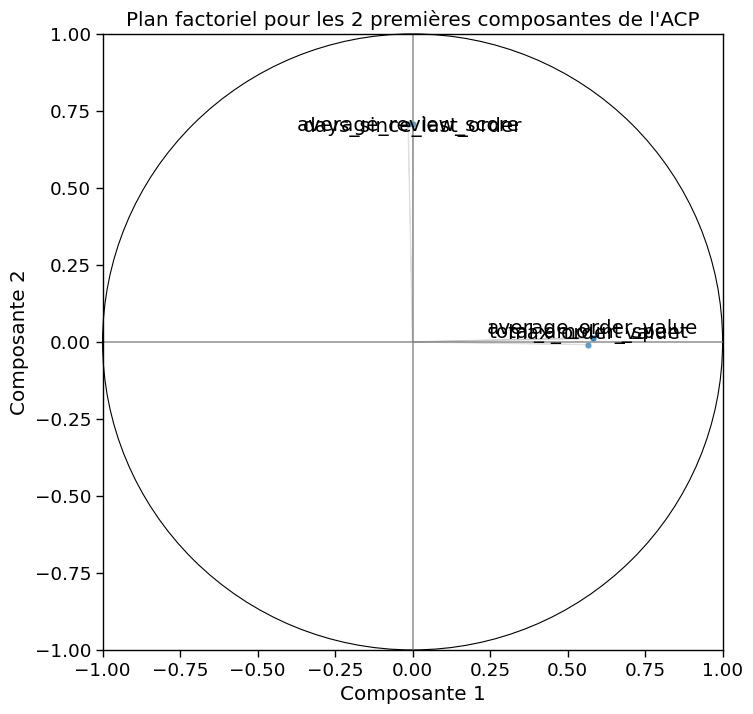

In [ ]:
# Configuration de l'affichage
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(8, 8))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP"
plt.title(chaine)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')

# Ajout du cercle de corrélation
ax = plt.gca()
ax.add_patch(Circle([0, 0], radius=1, color='black', fill=False, linestyle='-', clip_on=False))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Tracé des points
sns.scatterplot(x=x_pca, y=y_pca, alpha=0.7)
plt.plot([-1, 1], [0, 0], color='grey', alpha=0.8)
plt.plot([0, 0], [-1, 1], color='grey', alpha=0.8)

# Annotation des variables
for x, y, colonne in zip(x_pca, y_pca, colonnes_pca):
    plt.annotate(colonne, (x, y), textcoords="offset points",
                 xytext=(0, 5 + np.random.randint(-10, 10)),
                 ha='center')
    ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc='grey', ec='grey', alpha=0.2)

sns.set_context("paper", font_scale=1)
plt.show()


*tracer la somme cumulée de la variance expliquée par les composantes principales de l'ACP*

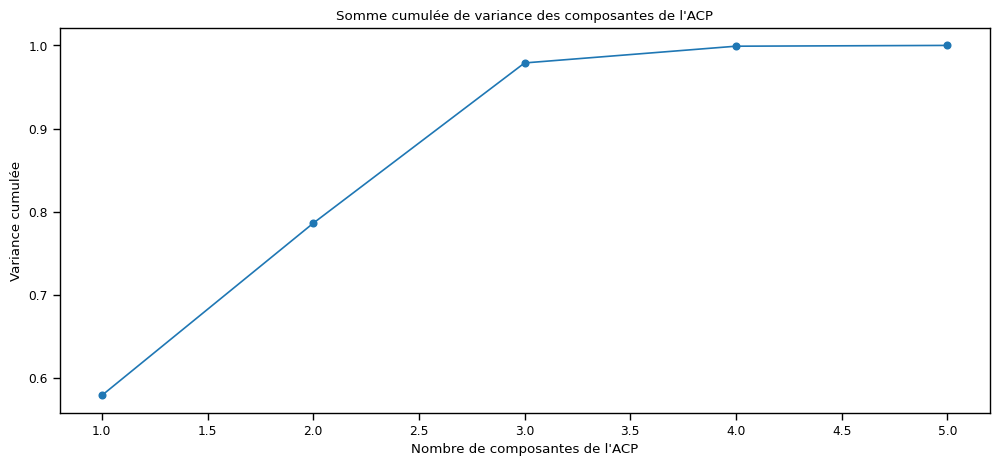

In [ ]:
# Exécution de l'ACP
pca = PCA(n_components=X.shape[1])  
pca_result = pca.fit_transform(X_scaled)

# Tracé de la somme cumulée de la variance expliquée
plt.figure(figsize=(12, 5))
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')

# Calcul et tracé de la variance cumulée
plt.plot(list(range(1, X.shape[1] + 1)), np.cumsum(pca.explained_variance_ratio_), marker='o')

# Affichage du graphique
plt.show()

Avec le graphe et le calcul de la variance cumulée qui est de l'ordre de 0.96% sur la composante 4 auquel nous allons projeté nos données

*Autre methode pour expliquer la variance,  un scree plot ou diagramme de dégringolade*

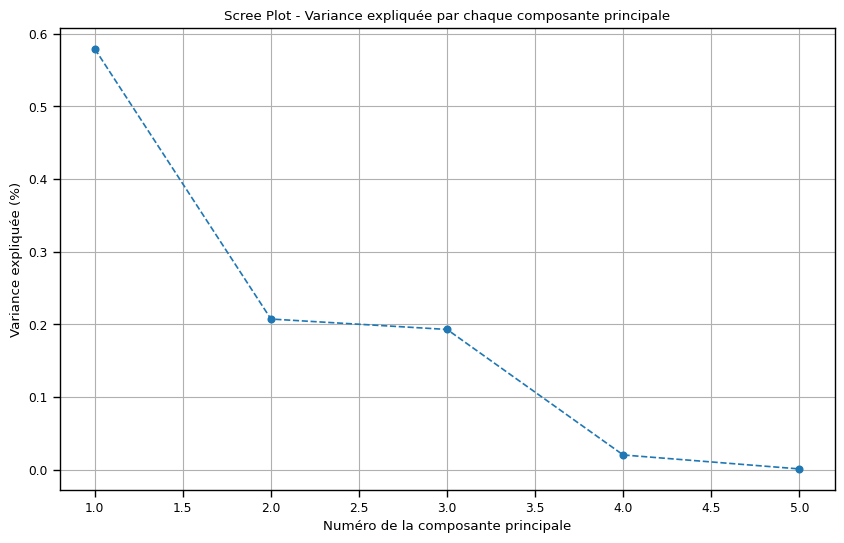

In [ ]:


# Exécution de l'ACP sur l'ensemble des données
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Récupération de la variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_

# Tracé du scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')

# Ajout des titres et labels
plt.title('Scree Plot - Variance expliquée par chaque composante principale')
plt.xlabel('Numéro de la composante principale')
plt.ylabel('Variance expliquée (%)')

# Affichage de la grille
plt.grid(True)

# Affichage du scree plot
plt.show()


*Plan factoriel pour les 2 premières composantes de l'ACP*

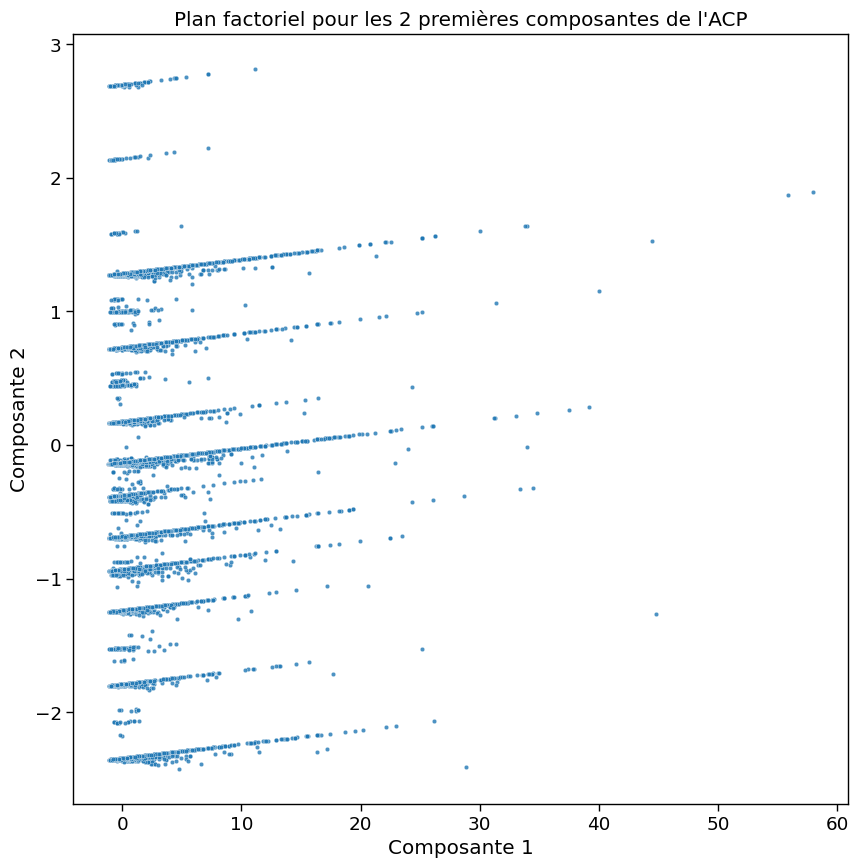

In [ ]:
# Exécution de l'ACP
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Récupération des résultats pour le scatterplot
x_show = pca_result[:, 0]
y_show = pca_result[:, 1]

# Visualisation du plan factoriel avec seaborn
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(10, 10))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP"
plt.title(chaine)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')

# Création du scatterplot
sns.scatterplot(x=x_show, y=y_show, alpha=0.8, s=10)

# Réinitialiser le contexte de seaborn
sns.set_context("paper", font_scale=1)

# Affichage du graphique
plt.show()

*Calcul de la variance expliquée cumulée des deux premières composantes*

In [ ]:
from sklearn.decomposition import PCA

# Initialisation de l'ACP avec 2 composantes principales
pca = PCA(n_components=2)

# Ajustement du modèle et transformation des données
pca.fit(X_scaled)

# Affichage de la variance expliquée cumulée
print("Variance expliquée cumulée des deux premières composantes :")
print(pca.explained_variance_ratio_.cumsum())

# Transformation des données avec l'ACP
X_trans = pca.transform(X_scaled)

Variance expliquée cumulée des deux premières composantes :
[0.57888989 0.78606453]


*visualiser le plan factoriel pour les composantes 1 et 3 de l'Analyse en Composantes Principales (ACP)*

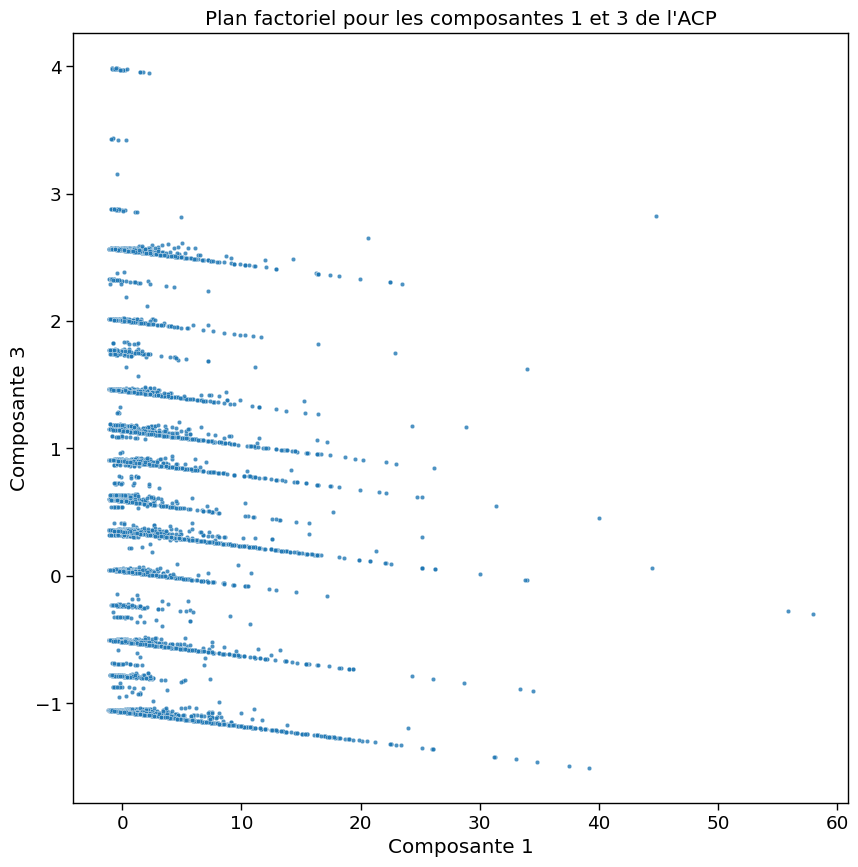

In [ ]:
# Exécution de l'ACP
pca = PCA(n_components=3)  # Garder au moins 3 composantes
pca_result = pca.fit_transform(X_scaled)

# Récupération des résultats pour le scatterplot, ici composantes 1 et 3
x_show = pca_result[:, 0]  # Première composante
y_show = pca_result[:, 2]  # Troisième composante

# Visualisation du plan factoriel avec seaborn
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(10, 10))
chaine = "Plan factoriel pour les composantes 1 et 3 de l'ACP"
plt.title(chaine)
plt.xlabel('Composante 1')
plt.ylabel('Composante 3')

# Création du scatterplot
sns.scatterplot(x=x_show, y=y_show, alpha=0.8, s=10)

# Réinitialiser le contexte de seaborn
sns.set_context("paper", font_scale=1)

# Affichage du graphique
plt.show()

In [ ]:
# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialisation de l'ACP avec 3 composantes principales
pca = PCA(n_components=3)

# Ajustement du modèle PCA
pca.fit(X_scaled)

# Variance expliquée cumulée pour les composantes 1 et 3
variance_expliquee = pca.explained_variance_ratio_.cumsum()
print("Variance expliquée cumulée pour les composantes 1 et 3:")
print("Composante 1:", variance_expliquee[0])
print("Composante 2:", variance_expliquee[1])
print("Composante 3:", variance_expliquee[2])

# Transformation des données avec l'ACP
X_trans = pca.transform(X_scaled)

Variance expliquée cumulée pour les composantes 1 et 3:
Composante 1: 0.5788898857480872
Composante 2: 0.7860645294855502
Composante 3: 0.9789169648190347


*visualiser le plan factoriel pour les composantes 2 et 3 de l'Analyse en Composantes Principales (ACP)*

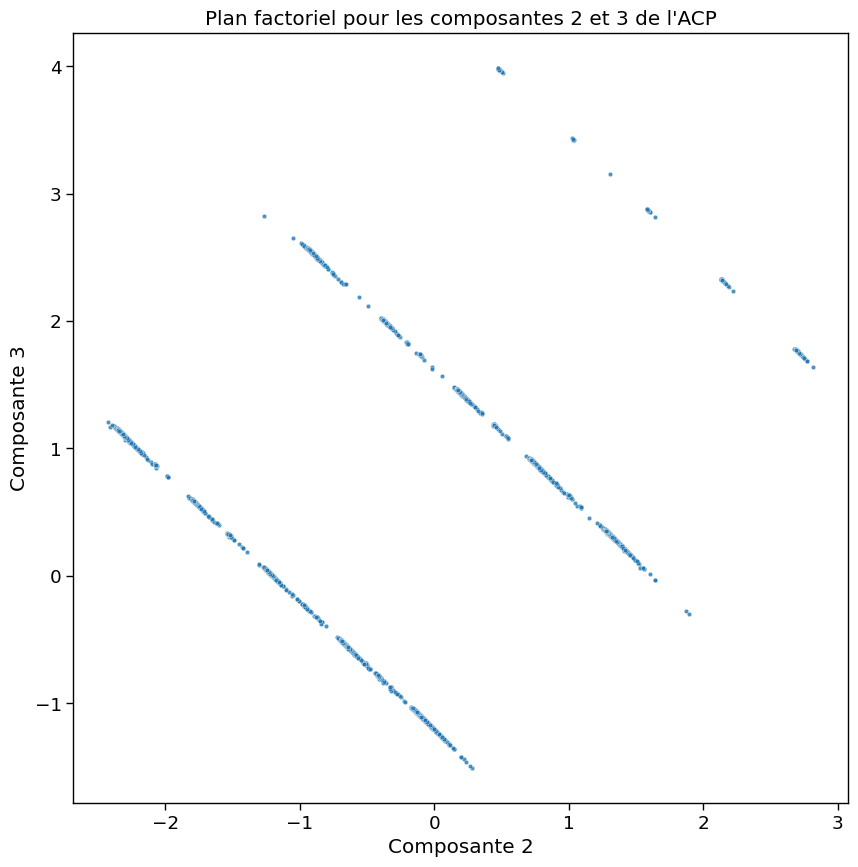

In [ ]:
# Exécution de l'ACP
pca = PCA(n_components=3)  
pca_result = pca.fit_transform(X_scaled)

# Récupération des résultats pour le scatterplot, ici composantes 2 et 3
x_show = pca_result[:, 1]  
y_show = pca_result[:, 2]  

# Visualisation du plan factoriel avec seaborn
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(10, 10))
chaine = "Plan factoriel pour les composantes 2 et 3 de l'ACP"
plt.title(chaine)
plt.xlabel('Composante 2')
plt.ylabel('Composante 3')

# Création du scatterplot
sns.scatterplot(x=x_show, y=y_show, alpha=0.8, s=10)

# Réinitialiser le contexte de seaborn
sns.set_context("paper", font_scale=1)

# Affichage du graphique
plt.show()

In [ ]:
# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialisation de l'ACP avec 3 composantes principales
pca = PCA(n_components=3)

# Ajustement du modèle PCA
pca.fit(X_scaled)

# Variance expliquée cumulée jusqu'aux composantes 2 et 3
variance_expliquee = pca.explained_variance_ratio_.cumsum()

print("Variance expliquée cumulée pour les composantes 2 et 3:")
print("Composante 2:", variance_expliquee[1])  
print("Composante 3:", variance_expliquee[2])  

# Transformation des données avec l'ACP
X_trans = pca.transform(X_scaled)

Variance expliquée cumulée pour les composantes 2 et 3:
Composante 2: 0.7860645294855502
Composante 3: 0.9789169648190347


*Heatmap des corrélations entre les composantes principales*

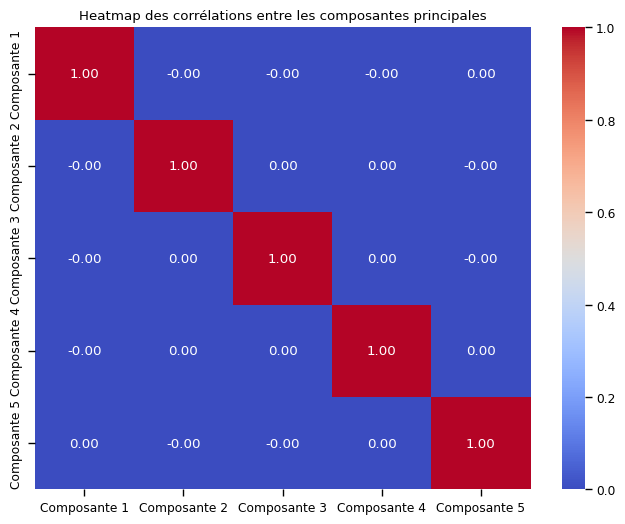

In [ ]:
# Exécution de l'ACP
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Calcul des corrélations entre les composantes principales
corr_matrix = np.corrcoef(pca_result.T)

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=[f'Composante {i+1}' for i in range(X.shape[1])], yticklabels=[f'Composante {i+1}' for i in range(X.shape[1])])
plt.title('Heatmap des corrélations entre les composantes principales')
plt.show()

**Analyse avec l'algorithme K-means**

*Nous allons faire un essais de clustering avec un k=5*

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Sélection des variables numériques
colonnes_numeriques = ['days_since_last_order', 'total_amount_spent',
                       'average_order_value', 'max_order_value', 'average_freight_value',
                        'average_review_score']

In [ ]:
# Création d'un DataFrame avec seulement les colonnes numériques
X_num = data_fichier_clients[colonnes_numeriques]

In [ ]:
# Normalisation des données
scaler_nor = StandardScaler()
X_scaler = scaler_nor.fit_transform(X_num)

In [ ]:
# Augmenter le nombre d'initialisations pour éviter les minima locaux
kmeans_5 = KMeans(n_clusters=5, n_init=100, random_state=42)
kmeans_5.fit(X_scaler)


KMeans(n_clusters=5, n_init=100, random_state=42)

Comme on a un nombre limité de variables, L'ACP est souvent utilisée pour réduire la dimensionnalité avant le clustering, dans ce cas on peut directement appliquer K-means sur les données normalisées.

In [ ]:
labels_5 = kmeans_5.labels_

*Trouver l'Optimum du Nombre de Clusters*

In [ ]:


inerties = []
for k in range(2, 10):
    kmeans_5 = KMeans(n_clusters=k, n_init=10)  # Ou n_init='auto'
    kmeans_5.fit(X)
    inerties.append(kmeans_5.inertia_)

Text(0.5, 1.0, 'Inertie vs nombre de classes')

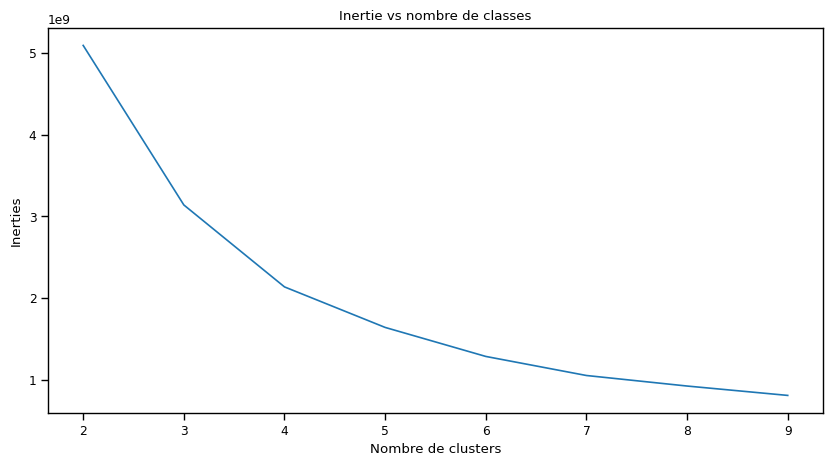

In [ ]:
# on represente le graphique
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), inerties)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inerties")
plt.title('Inertie vs nombre de classes')

*L'inertie continue toujours a baisser, mais on constate qu'un coude autour de la classe 3 et 6*

*Calcul des Scores de Silhouette*

Nous allons faire un clustering K-means pour plusieur taille de clusters et pour chacune de ces taille on calcul le coeficient de silhouette pour pouvoir choisir la taille de clusters la plus aproprié

In [ ]:

from sklearn.metrics import silhouette_score

In [ ]:
# Dictionnaire pour stocker les scores de silhouette
silhouettes_kmeans = {}

# Calculer le score de silhouette pour différents nombres de clusters
for k in range(2, 10):
    print(f"Calcul en cours pour k = {k}")
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)  # Initialiser KMeans
    kmeans.fit(X_scaler)  # Utiliser les données normalisées
    labels = kmeans.labels_  # Obtenir les labels des clusters
    silhouette_avg = silhouette_score(X_scaler, labels)  # Calculer le score de silhouette
    silhouettes_kmeans[k] = silhouette_avg  # Stocker le score dans le dictionnaire

Calcul en cours pour k = 2
Calcul en cours pour k = 3
Calcul en cours pour k = 4
Calcul en cours pour k = 5
Calcul en cours pour k = 6
Calcul en cours pour k = 7
Calcul en cours pour k = 8
Calcul en cours pour k = 9


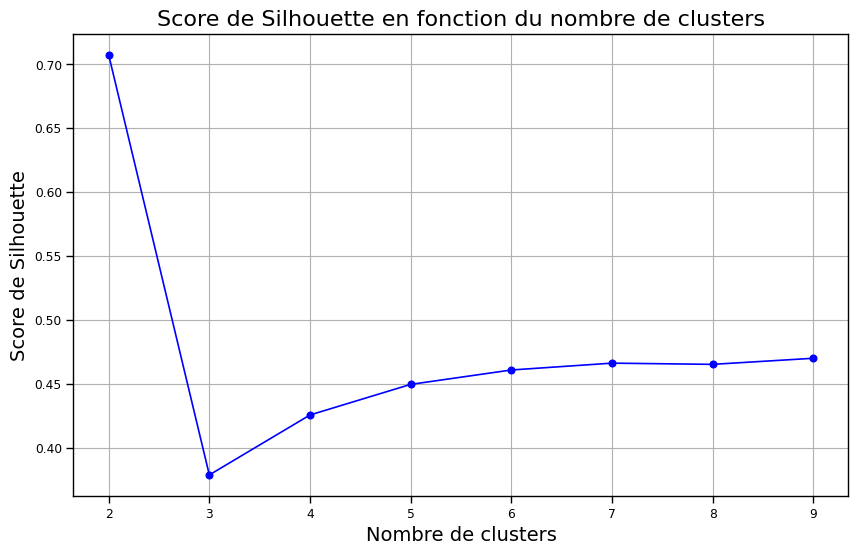

In [ ]:
# Tracer le score de silhouette en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(list(silhouettes_kmeans.keys()), list(silhouettes_kmeans.values()), marker='o', linestyle='-', color='b')
plt.title('Score de Silhouette en fonction du nombre de clusters', fontsize=16)
plt.xlabel('Nombre de clusters', fontsize=14)
plt.ylabel('Score de Silhouette', fontsize=14)
plt.xticks(range(2, 10))  
plt.grid(True)

# Afficher le graphique
plt.show()

Nous constatons que le coeficient de silhouette est beaucoup elevé entre 2, 5 et 6 donc il nous faut ce nombre de clusters.

*Calculer et Tracer l'Indice de Davies-Bouldin*

In [ ]:
from sklearn.metrics import davies_bouldin_score

In [ ]:
# Initialisation du dictionnaire pour stocker les indices de Davies-Bouldin
dbi_scores = {}

# Calcul des résultats de K-means pour différents nombres de clusters
for k in range(2, 10):
    print(f"Calcul en cours pour k = {k}")
    kmeans_5 = KMeans(n_clusters=k, n_init=10, verbose=0, random_state=0)
    kmeans_5.fit(X_scaler)
    labels = kmeans_5.labels_  # Obtenir les labels des clusters
    dbi_score = davies_bouldin_score(X_scaler, labels)  # Calculer l'indice de Davies-Bouldin
    dbi_scores[k] = dbi_score  # Stocker le score dans le dictionnaire

Calcul en cours pour k = 2
Calcul en cours pour k = 3
Calcul en cours pour k = 4
Calcul en cours pour k = 5
Calcul en cours pour k = 6
Calcul en cours pour k = 7
Calcul en cours pour k = 8
Calcul en cours pour k = 9


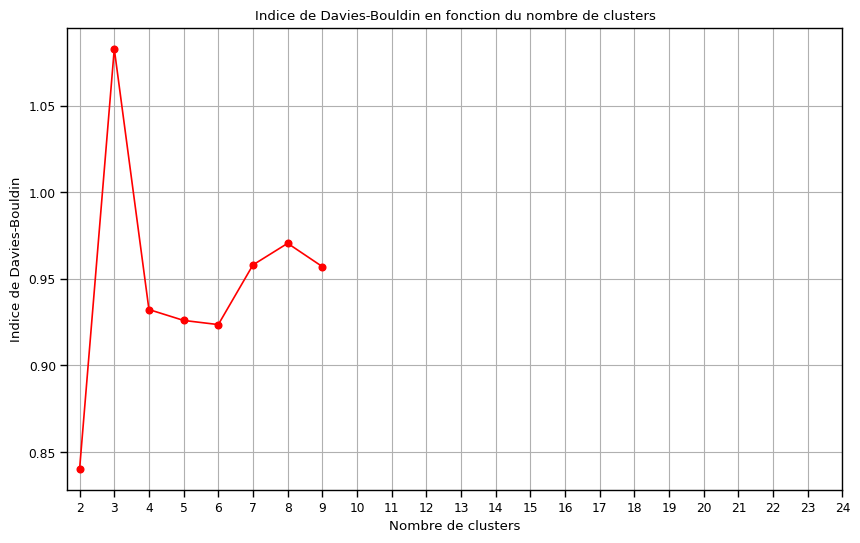

In [ ]:
# Tracer l'indice de Davies-Bouldin en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(list(dbi_scores.keys()), list(dbi_scores.values()), marker='o', color='r')
plt.title('Indice de Davies-Bouldin en fonction du nombre de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Indice de Davies-Bouldin')
plt.xticks(range(2, 25))
plt.grid(True)
plt.show()

**Procedons un K-means avec un K optimiser**


* K=6


Nous avons esssayé le preprocessor Standarcaler auquel nous avons vu que les clusters n'etait pas repartie. Mais avec Powertransformers ils sont tres bien repartie

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
data_fichier_clients.head()

,customer_unique_id,frequence,total_amount_spent,average_review_score,days_since_last_order,first_order_date,average_order_value,max_order_value,average_freight_value,most_frequent_payment_type
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,5.0,6,2018-05-10 10:56:27,129.90,129.90,12.00,credit_card
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,4.0,6,2018-05-07 11:11:27,18.90,18.90,8.29,credit_card
2,0000f46a3911fa3c0805444483337064,1,69.00,3.0,7,2017-03-10 21:05:03,69.00,69.00,17.22,credit_card
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,4.0,7,2017-10-12 20:29:41,25.99,25.99,17.63,credit_card
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,5.0,7,2017-11-14 19:45:42,180.00,180.00,16.89,credit_card


In [ ]:
# Sélectionner les colonnes numériques pertinentes pour KMeans
X = data_fichier_clients[['days_since_last_order', 'total_amount_spent',
                          'average_order_value', 'max_order_value',
                          'average_freight_value', 'average_review_score']]



In [ ]:
# Application du PowerTransformer
pt = PowerTransformer()
X_transformed = pt.fit_transform(X)


In [ ]:
# Appliquer KMeans avec k=6 clusters
n_clusters = 6  # Définir le nombre de clusters
kmeans_6 = KMeans(n_clusters=n_clusters, n_init=100, random_state=42)
kmeans_6.fit(X_transformed)


KMeans(n_clusters=6, n_init=100, random_state=42)

In [ ]:
# Ajouter les labels de clusters au DataFrame
data_fichier_clients['cluster'] = kmeans_6.labels_

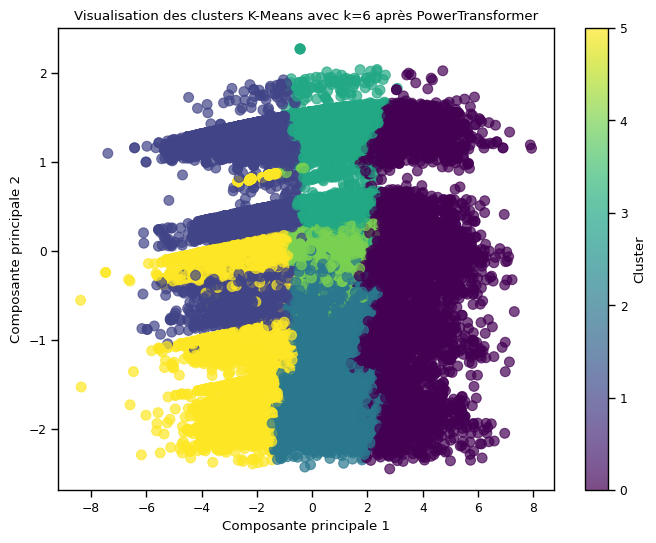

In [ ]:


# Réduction à 2 composantes principales pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_fichier_clients['cluster'], cmap='viridis', alpha=0.7, s=50)
plt.title('Visualisation des clusters K-Means avec k=6 après PowerTransformer')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Cluster')
plt.show()


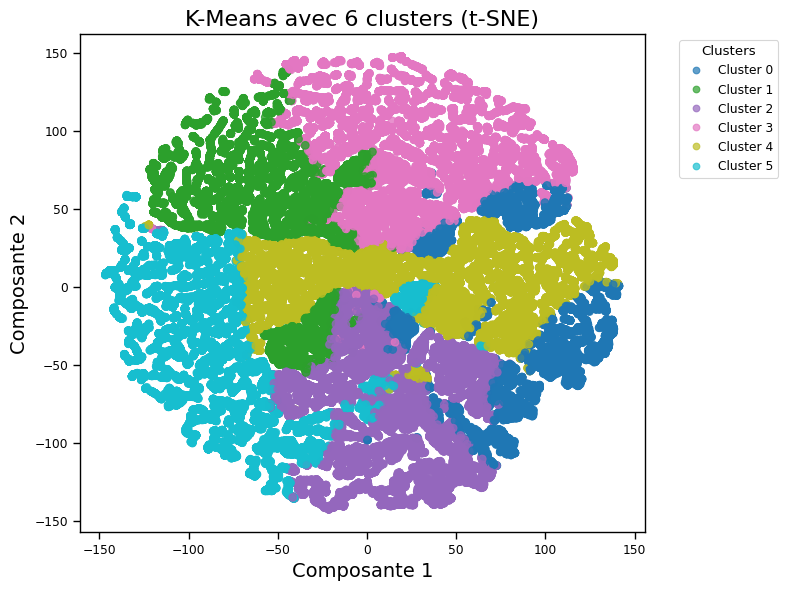

In [ ]:

from sklearn.manifold import TSNE

# Application de t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_transformed)

# Création de la figure pour K-Means avec 6 clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Visualisation avec t-SNE
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=data_fichier_clients['cluster'], cmap='tab10', alpha=0.8, s=30)
ax.set_title('K-Means avec 6 clusters (t-SNE)', fontsize=16)
ax.set_xlabel('Composante 1', fontsize=14)
ax.set_ylabel('Composante 2', fontsize=14)

# Ajouter la légende pour K-Means avec 6 clusters
handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
ax.legend(handles, [f'Cluster {i}' for i in range(6)], title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajuster l'affichage
plt.tight_layout()
plt.show()

*Le nombre de point du cluster_6*

In [ ]:
# Comptage du nombre d'observations dans chaque cluster
cluster_counts = pd.Series(data_fichier_clients['cluster']).value_counts()

# Afficher la répartition des clusters
print(cluster_counts)

cluster
4    18273
2    18271
3    17799
5    16271
1    14114
0     9989
Name: count, dtype: int64


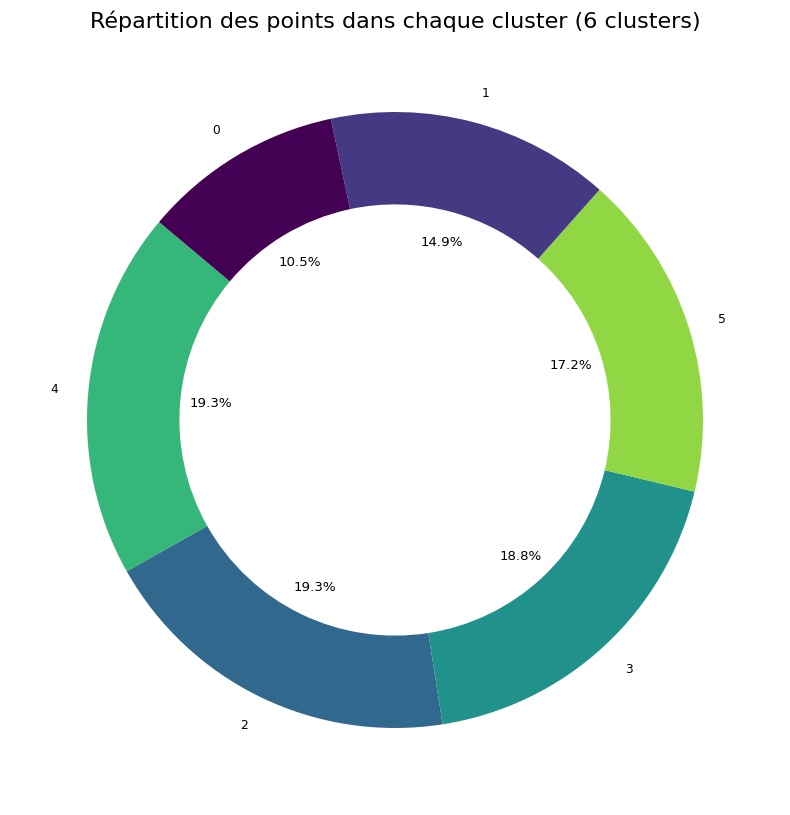

In [ ]:
import matplotlib.pyplot as plt

# Compter le nombre de points dans chaque cluster (pour 6 clusters)
cluster_counts_6 = pd.Series(data_fichier_clients['cluster']).value_counts()

# Taille de la figure
plt.figure(figsize=(10, 10))

# Création du graphique à secteurs
plt.pie(cluster_counts_6,
        labels=cluster_counts_6.index,
        autopct='%1.1f%%',
        colors=plt.cm.viridis(cluster_counts_6.index / cluster_counts_6.count()),
        startangle=140,  # Angle de départ pour la première tranche
        wedgeprops=dict(width=0.3))  

# Ajouter un titre
plt.title('Répartition des points dans chaque cluster (6 clusters)', fontsize=16)

# Afficher le graphique
plt.show()


Nous allons faire une statisque de chaque cluster et ajouter a notre dataframe afin de faire une comparaisons

In [ ]:
# Calculer les statistiques pour chaque cluster
clusters_statistic = data_fichier_clients.groupby('cluster').agg({
    'total_amount_spent': ['mean', 'std', 'min', 'max'],
    'days_since_last_order': ['mean', 'std', 'min', 'max'],
    'average_review_score': ['mean', 'std', 'min', 'max'],
    'average_order_value': ['mean', 'std', 'min', 'max'],
    'max_order_value': ['mean', 'std', 'min', 'max'],
    'average_freight_value': ['mean', 'std', 'min', 'max'],
})

# Stocker les statistiques dans le dictionnaire
clusters_statistics = {}  # Initialisation du dictionnaire
clusters_statistics['clusters_label_6'] = clusters_statistic  

# Afficher les statistiques pour 6 clusters
print(f"Statistiques pour {n_clusters} clusters:")
display(clusters_statistic)


Statistiques pour 6 clusters:


total_amount_spent                              days_since_last_order  \
                      mean         std    min       max                  mean   
cluster                                                                         
0               524.572864  470.341356  74.90  13440.00              6.365702   
1                37.970837   18.903840   2.29    248.40              7.006447   
2               128.502778   80.962904  28.00   2000.00              6.240053   
3               135.460117   79.438791  45.00   1640.70              7.006686   
4               125.543946   68.443431  37.90    932.22              6.000000   
5                35.026848   18.301076   0.85    240.00              6.000000   

                          average_review_score                                \
              std min max                 mean       std       min       max   
cluster                                                                        
0        0.486202   6   8             4.130709  1.261427  1.000000  5.000000   
1        0.080040   7   8             4.228697  1.144964  1.000000  5.000000   
2        0.430064   6   8             2.513613  1.233815  1.000000  4.142857   
3        0.081495   7   8             4.769121  0.426665  1.000000  5.000000   
4        0.000000   6   6             4.995323  0.048507  4.333333  5.000000   
5        0.000000   6   6             4.326343  1.109836  1.000000  5.000000   

        average_order_value                                max_order_value  \
                       mean         std        min     max            mean   
cluster                                                                      
0                475.921536  413.354886  67.217500  6735.0      483.897222   
1                 33.839678   13.660470   1.514286    69.9       34.031201   
2                106.432332   52.624287  17.847143   494.0      108.742318   
3                121.111809   60.854254  24.450000   546.9      122.611212   
4                111.466926   51.903984  19.083333   712.9      113.343441   
5                 31.668645   14.258251   0.850000   117.9       31.824289   

                                   average_freight_value                   \
                std    min     max                  mean        std   min   
cluster                                                                     
0        416.147577  69.90  6735.0             44.025850  33.050207  9.59   
1         13.696496   2.29    69.9             14.314374   5.132126  1.98   
2         53.563520  20.49   494.0             19.725774   9.577972  0.00   
3         61.265314  31.80   546.9             18.641067   7.979031  0.00   
4         52.700355  28.99   712.9             19.292128   9.400338  0.00   
5         14.288138   0.85   117.9             13.783704   6.078474  0.00   

                 
            max  
cluster          
0        409.68  
1        112.43  
2        121.73  
3        116.31  
4        140.52  
5         98.02

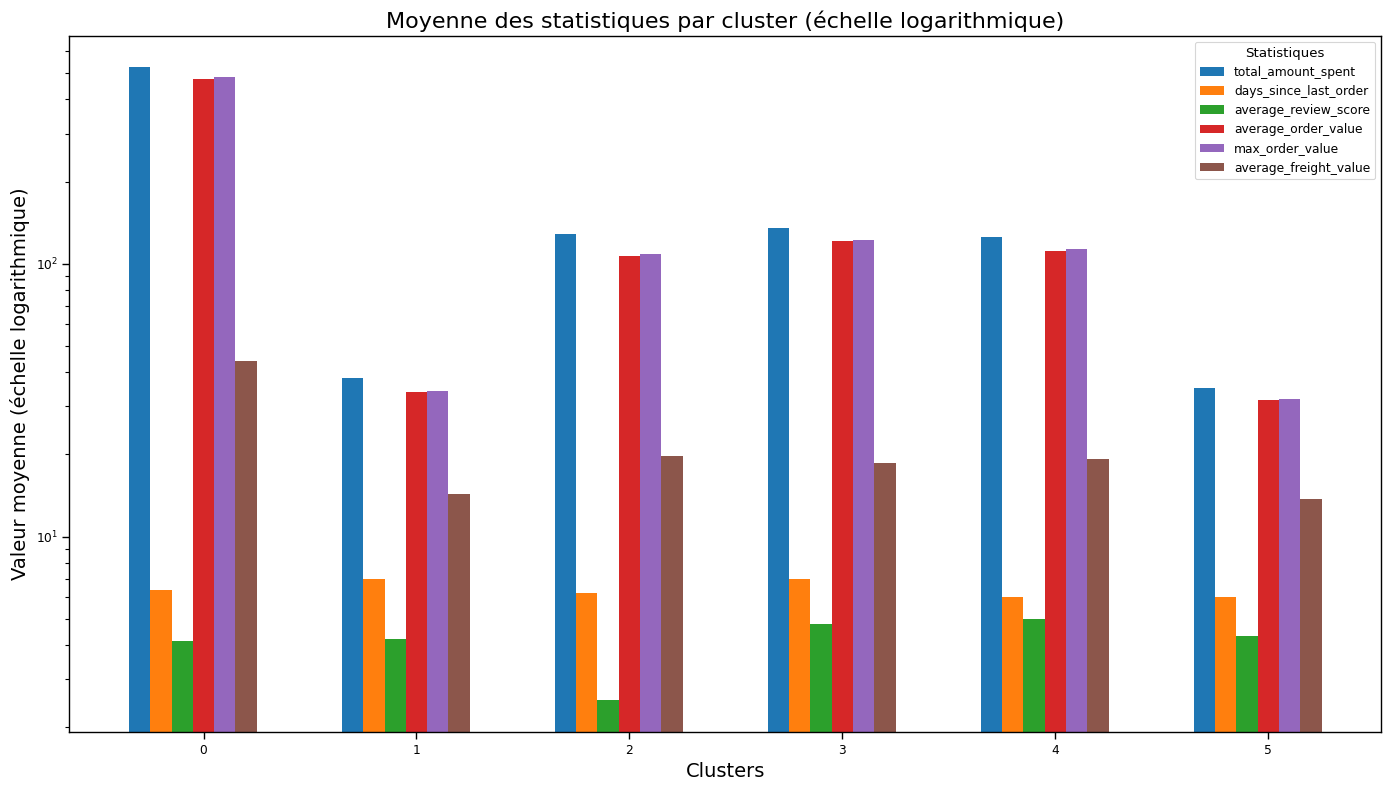

In [ ]:


# Extraire les moyennes pour chaque cluster
mean_stats = clusters_statistic.xs('mean', axis=1, level=1)

# Obtenir la liste des clusters et des colonnes
clusters = mean_stats.index
categories = mean_stats.columns

# Taille de la figure
plt.figure(figsize=(14, 8))

# Paramètres pour les barres
bar_width = 0.1
index = np.arange(len(clusters))  # Nombre de clusters

# Création des barres pour chaque statistique
for i, category in enumerate(categories):
    plt.bar(index + i * bar_width, mean_stats[category], bar_width, label=category)

# Ajouter les labels et le titre
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Valeur moyenne (échelle logarithmique)', fontsize=14)
plt.title('Moyenne des statistiques par cluster (échelle logarithmique)', fontsize=16)
plt.xticks(index + bar_width * (len(categories) / 2), clusters)
plt.yscale('log')  # Appliquer l'échelle logarithmique
plt.legend(title='Statistiques')

# Afficher le graphique
plt.tight_layout()
plt.show()




# ****Description des clusters K-means****

**Cluster 0 : « Acheteurs Premium à Dépenses Variables »**

Dépenses élevées, satisfaction modérée (4.00).
Ce groupe se compose de clients qui effectuent des achats variés, avec des montants allant jusqu'à 13 440, mais qui ne commandent pas fréquemment (6.36 en moyenne). Bien qu'ils aient une capacité d'achat significative, leur satisfaction semble être moins élevée par rapport à leurs dépenses.

**Cluster 1 : « Clients à petits achats fréquents »**
Dépenses modestes, satisfaction élevée (4.79).
Ces clients effectuent des achats réguliers mais à faible montant (moyenne de 37.97). Ils semblent être satisfaits de leurs petites commandes et achètent fréquemment, indiquant un intérêt constant pour les produits.

**Cluster 2 : « Acheteurs Modérés Insatisfaits »**

Dépenses modérées, faible satisfaction (2.67).
Ce cluster inclut des clients qui dépensent en moyenne 128.50, mais leur satisfaction est faible. Bien que leurs achats soient plus fréquents, environ 30.9 % d'entre eux ont recours à des crédits, suggérant une insatisfaction persistante.

**Cluster 3 : « Clients Réguliers et Satisfaits »**

Dépenses élevées, satisfaction élevée (4.92).
Comprend des clients qui dépensent de manière significative, avec une moyenne de 135.46, et qui sont très satisfaits de leurs expériences. Leur utilisation de crédits est courante (99 %), ce qui indique qu'ils sont à l'aise avec des dépenses plus importantes.

**Cluster 4 : « Clients à Fortes Dépenses Insatisfaits »**

Dépenses très élevées, faible satisfaction (2.56).
Ce groupe représente des clients qui réalisent des commandes conséquentes, avec une moyenne de 125.54, mais leur satisfaction est faible. Environ 78,6 % d'entre eux utilisent du crédit, indiquant qu'ils dépendent souvent de l'emprunt malgré leur insatisfaction.

**Cluster 5 : « Ultra-Dépensiers Satisfaits »**

Dépenses extrêmement élevées, satisfaction élevée (4.60).
Ces clients se distinguent par des dépenses très élevées, atteignant des montants pouvant atteindre plusieurs millions. Leur satisfaction est relativement élevée, et ils utilisent fréquemment le crédit (73,8 %), ce qui les place dans une catégorie d'élite parmi les dépensiers.

**DBSCAN**

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Calculer les distances des k-ièmes voisins
k = 4  # min_samples généralement choisi comme k
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_transformed)
distances, indices = neighbors_fit.kneighbors(X_transformed)
distances = np.sort(distances[:, k-1], axis=0)

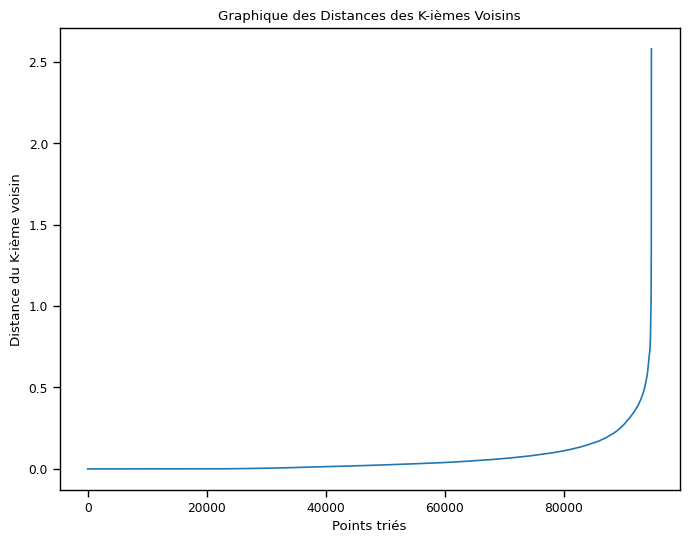

In [ ]:
# Tracer le graphique de la distance des k-ièmes voisins
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('Graphique des Distances des K-ièmes Voisins')
plt.xlabel('Points triés')
plt.ylabel('Distance du K-ième voisin')
plt.show()

In [ ]:
# Application de DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_transformed)

DBSCAN()

In [ ]:
# Obtenir les labels des clusters et les ajouter au DataFrame
dbscan_labels = dbscan.labels_
data_fichier_clients['dbscan_cluster'] = dbscan_labels


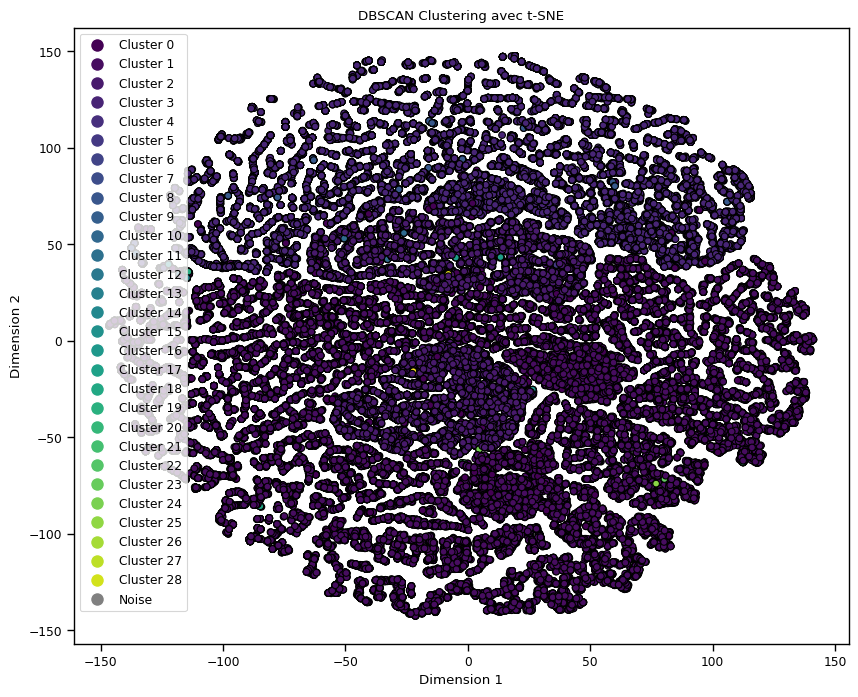

In [ ]:
# Appliquer t-SNE pour réduire les données à 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

# Créer une figure
plt.figure(figsize=(10, 8))

# Utiliser des couleurs distinctes pour chaque cluster
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis', marker='o', edgecolor='k')

# Créer une légende personnalisée
unique_labels = np.unique(dbscan_labels)
num_clusters = len(unique_labels)

handles = [plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=plt.cm.viridis(i / num_clusters),
                       markersize=10, label=f'Cluster {i}')
           for i in unique_labels if i != -1]
handles.append(plt.Line2D([0], [0], marker='o', color='w',
                           markerfacecolor='gray', markersize=10, label='Noise'))

plt.legend(handles=handles, loc='best')

# Ajouter les labels et le titre
plt.title('DBSCAN Clustering avec t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Afficher le graphique
plt.show()

In [ ]:
# Statistiques des clusters DBSCAN
dbscan_cluster_stats = clusters_statistic = data_fichier_clients.groupby('cluster').agg({
    'total_amount_spent': ['mean', 'std', 'min', 'max'],
    'days_since_last_order': ['mean', 'std', 'min', 'max'],
    'average_review_score': ['mean', 'std', 'min', 'max'],
    'average_order_value': ['mean', 'std', 'min', 'max'],
    'max_order_value': ['mean', 'std', 'min', 'max'],
    'average_freight_value': ['mean', 'std', 'min', 'max']
})

# Afficher les statistiques
display(dbscan_cluster_stats)

total_amount_spent                              days_since_last_order  \
                      mean         std    min       max                  mean   
cluster                                                                         
0               524.572864  470.341356  74.90  13440.00              6.365702   
1                37.970837   18.903840   2.29    248.40              7.006447   
2               128.502778   80.962904  28.00   2000.00              6.240053   
3               135.460117   79.438791  45.00   1640.70              7.006686   
4               125.543946   68.443431  37.90    932.22              6.000000   
5                35.026848   18.301076   0.85    240.00              6.000000   

                          average_review_score                                \
              std min max                 mean       std       min       max   
cluster                                                                        
0        0.486202   6   8             4.130709  1.261427  1.000000  5.000000   
1        0.080040   7   8             4.228697  1.144964  1.000000  5.000000   
2        0.430064   6   8             2.513613  1.233815  1.000000  4.142857   
3        0.081495   7   8             4.769121  0.426665  1.000000  5.000000   
4        0.000000   6   6             4.995323  0.048507  4.333333  5.000000   
5        0.000000   6   6             4.326343  1.109836  1.000000  5.000000   

        average_order_value                                max_order_value  \
                       mean         std        min     max            mean   
cluster                                                                      
0                475.921536  413.354886  67.217500  6735.0      483.897222   
1                 33.839678   13.660470   1.514286    69.9       34.031201   
2                106.432332   52.624287  17.847143   494.0      108.742318   
3                121.111809   60.854254  24.450000   546.9      122.611212   
4                111.466926   51.903984  19.083333   712.9      113.343441   
5                 31.668645   14.258251   0.850000   117.9       31.824289   

                                   average_freight_value                   \
                std    min     max                  mean        std   min   
cluster                                                                     
0        416.147577  69.90  6735.0             44.025850  33.050207  9.59   
1         13.696496   2.29    69.9             14.314374   5.132126  1.98   
2         53.563520  20.49   494.0             19.725774   9.577972  0.00   
3         61.265314  31.80   546.9             18.641067   7.979031  0.00   
4         52.700355  28.99   712.9             19.292128   9.400338  0.00   
5         14.288138   0.85   117.9             13.783704   6.078474  0.00   

                 
            max  
cluster          
0        409.68  
1        112.43  
2        121.73  
3        116.31  
4        140.52  
5         98.02

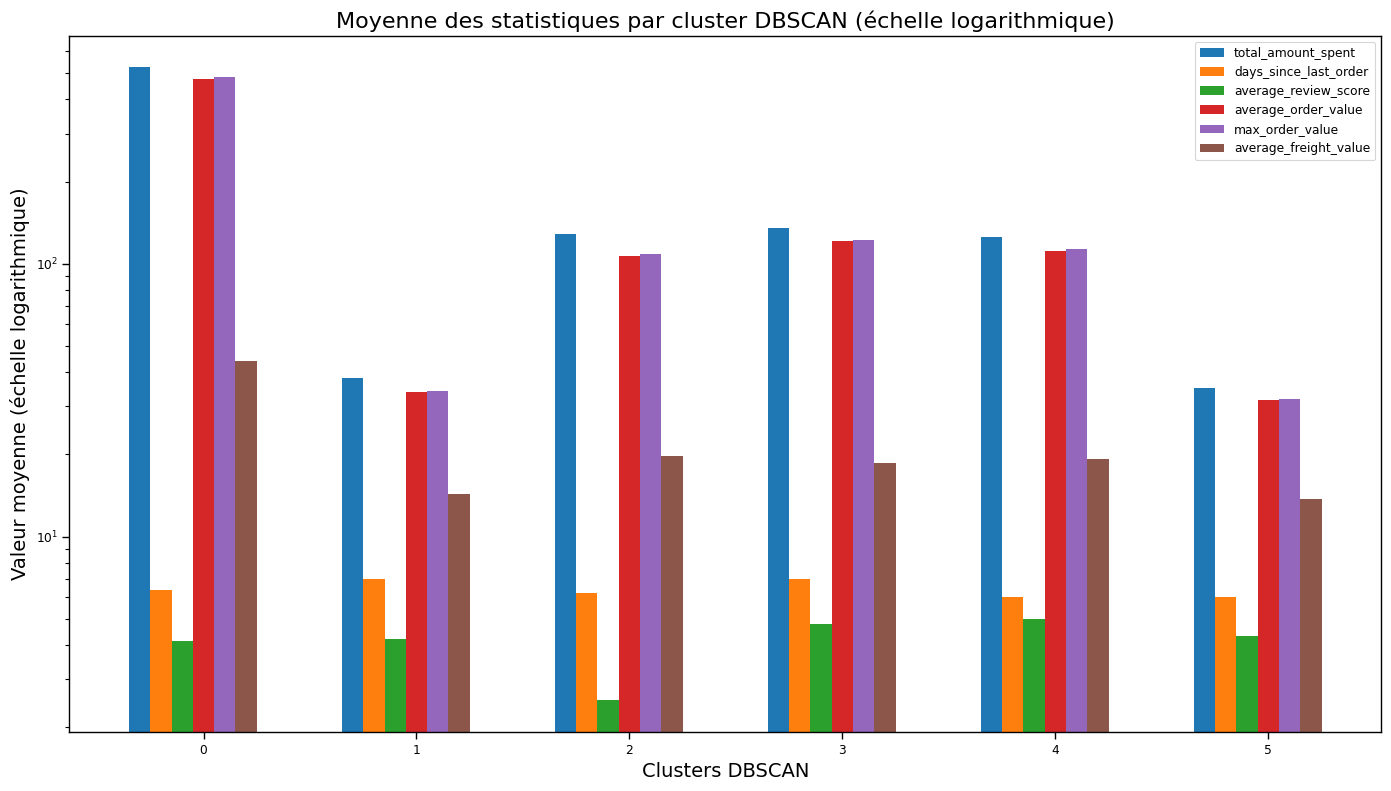

In [ ]:
# Extraire les moyennes des statistiques pour chaque cluster DBSCAN
mean_stats_dbscan = dbscan_cluster_stats.xs('mean', axis=1, level=1)

# Obtenir la liste des clusters DBSCAN et des colonnes
clusters_dbscan = mean_stats_dbscan.index
categories_dbscan = mean_stats_dbscan.columns

# Taille de la figure
plt.figure(figsize=(14, 8))

# Paramètres pour les barres
bar_width = 0.1
index = np.arange(len(clusters_dbscan))  # Nombre de clusters

# Création des barres pour chaque statistique
for i, category in enumerate(categories_dbscan):
    plt.bar(index + i * bar_width, mean_stats_dbscan[category], bar_width, label=category)

# Ajouter les labels et le titre
plt.xlabel('Clusters DBSCAN', fontsize=14)
plt.ylabel('Valeur moyenne (échelle logarithmique)', fontsize=14)
plt.title('Moyenne des statistiques par cluster DBSCAN (échelle logarithmique)', fontsize=16)
plt.xticks(index + bar_width * (len(categories_dbscan) / 2), clusters_dbscan)
plt.yscale('log')  # Appliquer l'échelle logarithmique
plt.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()


In [ ]:
# nous dit combien ya dans les clusters
pd.Series(dbscan.labels_).value_counts()

,count
0,54091
2,23537
1,15729
-1,869
3,121
7,106
6,43
11,34
13,18
5,17


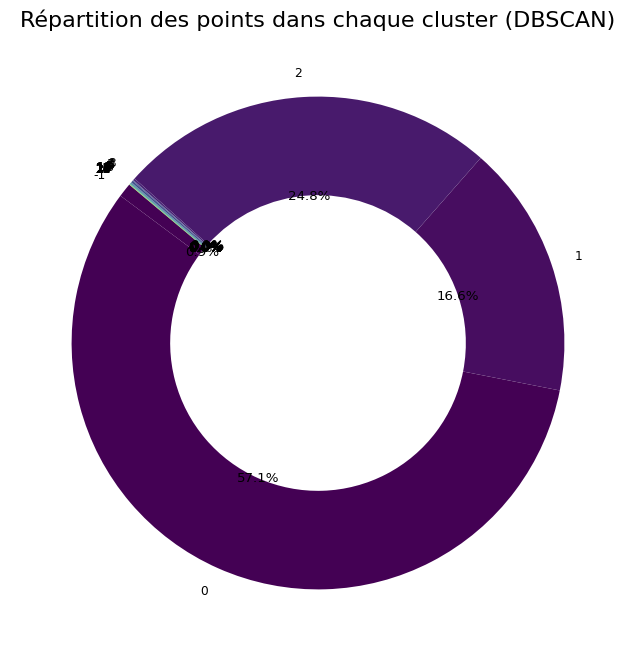

In [ ]:
# Compter le nombre de points dans chaque cluster pour DBSCAN
cluster_counts_dbscan = pd.Series(dbscan.labels_).value_counts().sort_index()

# Taille de la figure
plt.figure(figsize=(8, 8))

# Création du graphique à secteurs pour les clusters DBSCAN
plt.pie(cluster_counts_dbscan,
        labels=cluster_counts_dbscan.index,
        autopct='%1.1f%%',
        colors=plt.cm.viridis(cluster_counts_dbscan.index / len(cluster_counts_dbscan.index)),
        startangle=140,  # Angle de départ pour la première tranche
        wedgeprops=dict(width=0.4))

# Ajouter un titre
plt.title('Répartition des points dans chaque cluster (DBSCAN)', fontsize=16)

# Afficher le graphique
plt.show()


# **Tester un clusterring K-means avec les variable qualitatives**


In [ ]:
# Import des bibliothèques nécessaires
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Sélectionner les variables numériques et catégorielles
variable_numerique = ['days_since_last_order', 'total_amount_spent',
                       'average_order_value', 'max_order_value', 'average_freight_value',
                        'average_review_score']

variable_categorielle = ['most_frequent_payment_type']

# Créer les préprocesseurs pour les variables quantitatives et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', PowerTransformer(), variable_numerique),  # Appliquer PowerTransformer aux variables numériques
        ('cat', OneHotEncoder(handle_unknown='ignore'), variable_categorielle)  # Appliquer OneHotEncoder à la variable catégorielle
    ]
)

# Appliquer les transformations (variables numériques et catégorielles combinées)
Y = data_fichier_clients[variable_numerique + variable_categorielle]

# Prétraitement des données
Y_transformed = preprocessor.fit_transform(Y)


In [ ]:
# Appliquer KMeans avec k=6 clusters
kmeans_6 = KMeans(n_clusters=6, n_init=100, random_state=42)
kmeans_6.fit(Y_transformed)
labels_6 = kmeans_6.labels_

# Ajouter les labels de clusters au DataFrame
data_fichier_clients['cluster_cat'] = labels_6

In [ ]:
# Afficher la répartition des clusters
cluster_counts = pd.Series(labels_6).value_counts()
print("Répartition des clusters :\n", cluster_counts)

Répartition des clusters :
 2    18273
5    18198
1    17805
0    16446
3    14121
4     9874
Name: count, dtype: int64


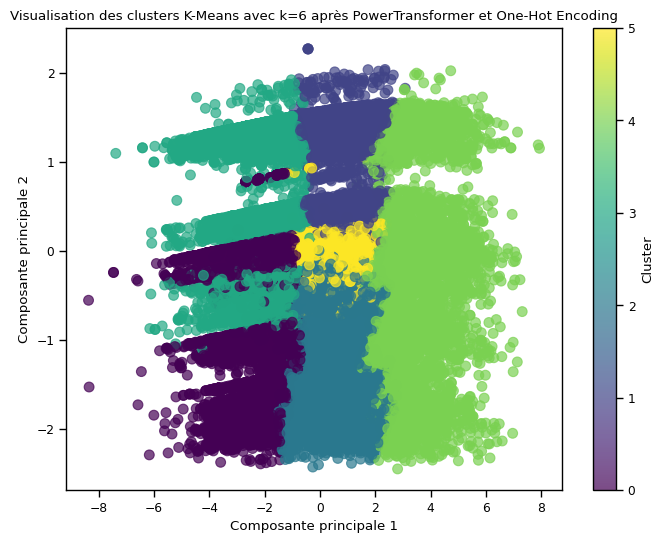

In [ ]:
# Visualisation des clusters après réduction de dimension avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_6, cmap='viridis', alpha=0.7, s=50)
plt.title('Visualisation des clusters K-Means avec k=6 après PowerTransformer et One-Hot Encoding')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
data_fichier_clients['most_frequent_payment_type'].value_counts()

,count
most_frequent_payment_type,
credit_card,71195
boleto,18576
voucher,3484
debit_card,1461


Nous avons constaté que la variable catégorielle sélectionnée contient peu de catégories de paiement, ce qui risque de limiter son impact sur la mise en œuvre du clustering. Par conséquent, il n'est pas recommandé d'utiliser un algorithme de K-means avec des variables catégorielles.

# **Clustering Hiérarchique**

Non applicable en raison d'un problème de mémoire.

Si cela avait été possible, voici les étapes à suivre :

In [ ]:
*Classification Ascendante Hiérarchique (CAH)*

import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd


# Calcul de la matrice des distances
distance_matrix = ssd.pdist(X_transformed, metric='euclidean')

# Création de la matrice carrée des distances
distance_square_matrix = ssd.squareform(distance_matrix)

# Création du dendrogramme
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(distance_square_matrix, method='ward'))
plt.title('Dendrogramme')
plt.xlabel('Index des échantillons')
plt.ylabel('Distance')
plt.show()

*Calcul du score de silhoutte de CAH*
from sklearn.cluster import AgglomerativeClustering


# Liste des nombres de clusters à tester
n_clusters_list = range(2, 11)

# Initialisation d'une liste pour stocker les scores de silhouette
silhouette_scores = []

# Boucle sur les différents nombres de clusters
for n_clusters in n_clusters_list:
    # Appliquer le clustering hiérarchique avec le nombre de clusters donné
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    labels = clustering.fit_predict(X_transformed)

    # Calculer le score de silhouette
    silhouette_avg = silhouette_score(X_transformed, labels)
    silhouette_scores.append(silhouette_avg)



    # Tracé du score de silhouette en fonction du nombre de clusters
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_list, silhouette_scores, 'bo-', color='orange')
plt.title("Score de Silhouette pour différents nombres de clusters")
plt.xlabel("Nombre de Clusters")
plt.ylabel("Score de Silhouette")
plt.grid(True)
plt.show()



*Calcul et tracé du coefficient de Davies-Bouldin*

# Liste des nombres de clusters à tester
n_clusters_list = range(2, 11)

# Initialisation d'une liste pour stocker les scores de Davies-Bouldin
davies_bouldin_scores = []

# Boucle sur les différents nombres de clusters
for n_clusters in n_clusters_list:
    # Appliquer le clustering hiérarchique avec le nombre de clusters donné
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    labels = clustering.fit_predict(X_transformed)

    # Calculer le score de Davies-Bouldin
    db_score = davies_bouldin_score(X_transformed, labels)
    davies_bouldin_scores.append(db_score)

    # Tracé du score de Davies-Bouldin en fonction du nombre de clusters
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_list, davies_bouldin_scores, 'bo-', color='green')
plt.title("Score de Davies-Bouldin pour différents nombres de clusters")
plt.xlabel("Nombre de Clusters")
plt.ylabel("Score de Davies-Bouldin")
plt.grid(True)
plt.show()
num_clusters = 4

# Découpage des clusters à partir de la matrice de linkage
clusters = sch.fcluster(sch.linkage(X_transformed, method='ward'), num_clusters, criterion='maxclust')

# Ajout des étiquettes de clusters au DataFrame original en utilisant .loc pour éviter l'avertissement
data_fichier_clients.loc[:, 'hierarchical_cluster'] = clusters

# Affichage des premières lignes du DataFrame avec les clusters
display(data_fichier_clients.head())
X_pca_2d = X_pca[:, :2]

# Création d'un DataFrame pour la visualisation
visualization_df = pd.DataFrame(X_pca_2d, columns=['PCA1', 'PCA2'])
visualization_df['Cluster'] = clusters

# Visualisation des clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=visualization_df, s=100, alpha=0.7)
plt.title('Visualisation des clusters hiérarchiques')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()

*Le nombre de point de chaque cluster*

# Compter le nombre de points dans chaque cluster
cluster_counts_hierarchical = pd.Series(clusters).value_counts().sort_index()


display(cluster_counts_hierarchical)



# Compter le nombre de points dans chaque cluster pour les clusters hiérarchiques
cluster_counts_hierarchical = pd.Series(clusters).value_counts().sort_index()

# Taille de la figure
plt.figure(figsize=(8, 8))

# Création du graphique à secteurs pour les clusters hiérarchiques
plt.pie(cluster_counts_hierarchical,
        labels=cluster_counts_hierarchical.index,
        autopct='%1.1f%%',
        colors=plt.cm.viridis(cluster_counts_hierarchical.index / len(cluster_counts_hierarchical.index)),
        startangle=140,  # Angle de départ pour la première tranche
        wedgeprops=dict(width=0.4))

# Ajouter un titre
plt.title('Répartition des points dans chaque cluster (Hiérarchique)', fontsize=16)

# Afficher le graphique
plt.show()

# Affichage des statistiques des clusters
cluster_stats = data_fichier_clients.groupby('cluster').agg({
    'total_amount_spent': ['mean', 'std', 'min', 'max'],
    'days_since_last_order': ['mean', 'std', 'min', 'max'],
    'average_review_score': ['mean', 'std', 'min', 'max'],
    'average_order_value': ['mean', 'std', 'min', 'max'],
    'max_order_value': ['mean', 'std', 'min', 'max'],
    'average_freight_value': ['mean', 'std', 'min', 'max']
})

display(cluster_stats)


# Extraire les moyennes des statistiques pour chaque cluster hiérarchique
mean_stats = cluster_stats.xs('mean', axis=1, level=1)

# Obtenir la liste des clusters et des colonnes
clusters = mean_stats.index
categories = mean_stats.columns

# Taille de la figure
plt.figure(figsize=(14, 8))

# Paramètres pour les barres
bar_width = 0.1
index = np.arange(len(clusters))  # Nombre de clusters

# Création des barres pour chaque statistique
for i, category in enumerate(categories):
    plt.bar(index + i * bar_width, mean_stats[category], bar_width, label=category)

# Ajouter les labels et le titre
plt.xlabel('Clusters Hiérarchiques', fontsize=14)
plt.ylabel('Valeur moyenne (échelle logarithmique)', fontsize=14)
plt.title('Moyenne des statistiques par cluster hiérarchique (échelle logarithmique)', fontsize=16)
plt.xticks(index + bar_width * (len(categories) / 2), clusters)
plt.yscale('log')  # Appliquer l'échelle logarithmique
plt.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (<ipython-input-62-bd9abbec1d82>, line 1)